In [27]:
import numpy as np
import scipy.stats
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = [13, 5]

In [37]:
omega = 1.0
rho = 0.05
tau = 0.5
beta = 0.27
T = 15
initial_dist = scipy.stats.norm(np.power(2, -0.5), 0.5)

# xi = 1/np.sqrt(rho)
xi = 0

# phi = lambda x: beta*jnp.sign(x);
phi = lambda x: np.zeros_like(x)

# Discretization
order = 2
order_idx = (order//2)

Nx = 50
Nt = 100

xs = np.linspace(-5, 5, Nx+2*order_idx)
dx = xs[1] - xs[0]
ts = np.linspace(0, T, Nt)
dt = ts[1] - ts[0]

In [38]:
def calculate_gamma(x, xi, qt, rt):
    y = tau*omega*qt*xi - phi(x)
    y -= x*(tau*omega*np.square(qt) - rt + 0.5*np.square(tau)*(1+omega*np.square(qt)))
    return y

def calculate_q(Pt, xs):
    return np.sqrt(rho)*np.dot(Pt, xs)*dx

def calculate_r(Pt, xs):
    px = phi(xs)
    return np.dot(xs*px, Pt)*dx


def d_central(fun, dx, order):
    kernels = {
        '12': np.array([-0.5, 0, 0.5]) / dx,
        '22': np.array([1, -2, 1]) / np.square(dx),
        
        '14': np.array([-1/12, -8/12, 0, 8/12, -1/12]) / dx,
        '24': np.array([-1/12, 16/12, -30/12, 16/12, -1/12]) / np.square(dx),
        
        '16': np.array([-1/60, -9/60, -45/60, 0, 45/60, -9/60, 1/60]) / dx,
        '26': np.array([2/180, -27/180, 270/180, -490/180, 270/180, -27/180, 2/180]) / np.square(dx),
        
        '18': np.array([3/840, -32/840, 168/840, -672/840, 0, 672/840, -168/840, 32/840, -3/840]) / dx,
        '28': np.array([-1/560, 8/315, -1/5, 8/5, -205/72, 8/5, -1/5, 8/315, -1/560]) / np.square(dx)
    }
    
    kernel = kernels[order]
    return np.convolve(fun, kernel, mode='valid')

In [44]:
P = np.zeros((Nt, Nx+2*order_idx))
ddP = np.zeros((Nt, Nx+2*order_idx))
Gamma = np.zeros((Nt, Nx+2*order_idx))
dP = np.zeros((Nt, Nx+2*order_idx))
dPdt = np.zeros((Nt, Nx+2*order_idx))

Q = np.zeros(Nt)
P[0] = initial_dist.pdf(xs)

for t in range(0,Nt-1):
    Pt = P[t]
    qt = calculate_q(Pt[order_idx:-order_idx], xs[order_idx:-order_idx])
    rt = calculate_r(Pt[order_idx:-order_idx], xs[order_idx:-order_idx])

    gp = calculate_gamma(xs, xi, qt, rt)
    dgp = d_central(gp*Pt, dx, f"1{order}")
        
    ddp = 0.5*np.square(tau)*(1 + omega*np.square(qt))*d_central(Pt, dx, f"2{order}")

    P[t+1, order_idx:-order_idx] = Pt[order_idx:-order_idx] + (-dgp + ddp)*dt
    Q[t] = qt
    ddP[t, order_idx:-order_idx] = ddp
    dP[t, order_idx:-order_idx] = dgp
    Gamma[t] = gp
    dPdt[t, order_idx:-order_idx] = ddp - dgp

In [47]:
inter_vars = {
    'P': P,
    'dP': dP,
    'ddP': ddP,
    'dPdt': dPdt,
    'gamma': Gamma
}

def plot_p(t=0, var='P'):
    plt.plot(xs, inter_vars[var][t])
    # plt.ylim((0, 1))
    
    plt.xlabel("$x$")
    plt.ylabel(f"{var}")

t_slider = widgets.IntSlider(min=0, max=Nt-1, step=1, value=0)
var_select = widgets.Dropdown(options=inter_vars.keys())
interact(plot_p, t=t_slider, var=var_select);

interactive(children=(IntSlider(value=0, description='t', max=99), Dropdown(description='var', options=('P', '…

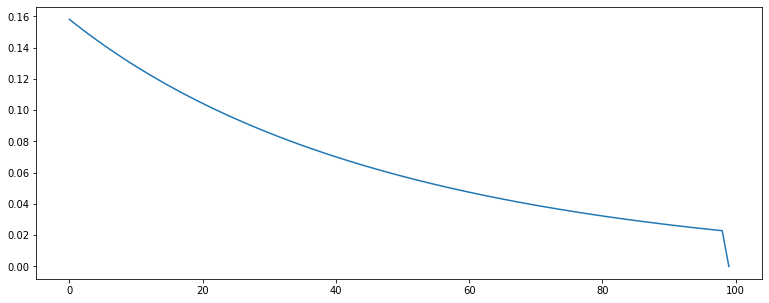

In [48]:
plt.plot(Q)